In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from sklearn.cluster import *

<br>

# Data Sets
---

We will use several different data set in the following.

<br>

### Simple data set

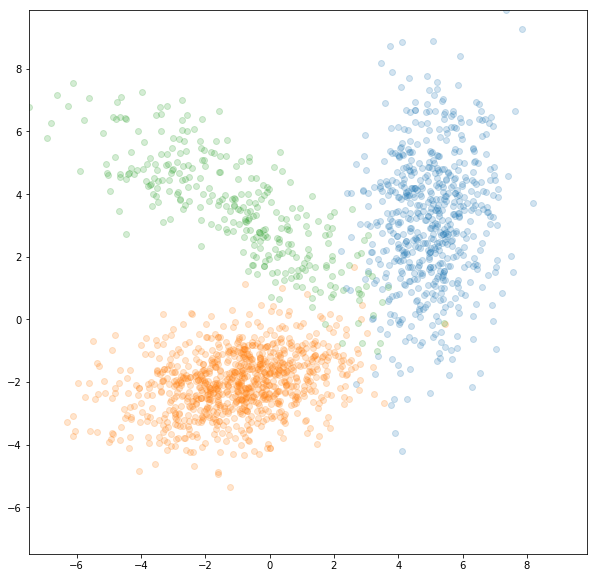

In [35]:
class DataSet:
    
    @property
    def all_points(self):
        return np.concatenate(self.clusters, axis=0)
    

class SimpleDataSet(DataSet):
    cluster_1 = np.random.multivariate_normal(
        mean=np.array([5.0, 3.0]),
        cov=np.array([[1.0, 0.2],
                      [0.2, 5.0]]),
        size=600)

    cluster_2 = np.random.multivariate_normal(
        mean=np.array([-1., -2.]),
        cov=np.array([[3.0, 0.5],
                      [0.5, 1.0]]),
        size=900)

    cluster_3 = np.random.multivariate_normal(
        mean=np.array([-1, 3.5]),
        cov=np.array([[5.0, -3.],
                      [-3., 3.0]]),
        size=300)
    
    @property
    def clusters(self):
        return (self.cluster_1, self.cluster_2, self.cluster_3)


def display(clusters, centroids=None):
    all_points = np.concatenate(clusters, axis=0)
    min_x, max_x = np.min(all_points[:,0]), np.max(all_points[:,0])
    min_y, max_y = np.min(all_points[:,1]), np.max(all_points[:,1])
    
    plt.figure(figsize=(10, 10))
    for cluster in clusters:
        plt.scatter(cluster[:,0], cluster[:,1], alpha=0.2)
    if centroids is not None:
        plt.scatter(centroids[:,0], centroids[:,1], marker='o', color='r')
    
    plt.xlim(min(min_x, min_y), max(max_x, max_y))
    plt.ylim(min(min_x, min_y), max(max_x, max_y))
    plt.show()


display(SimpleDataSet().clusters)

<br>

### Thin clusters

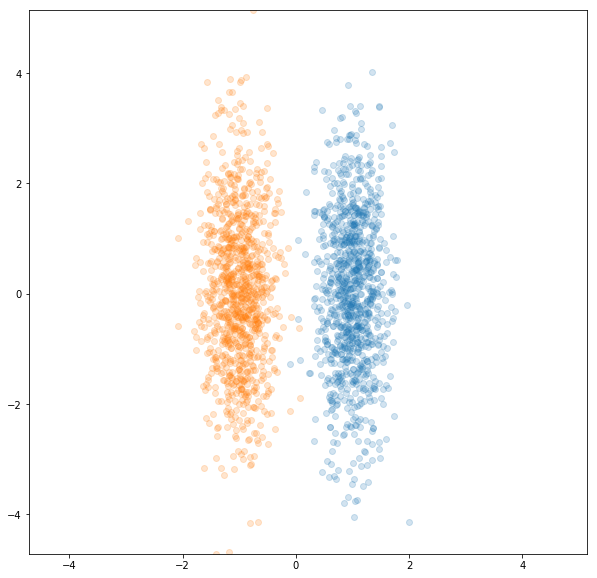

In [36]:
class ThinClusters(DataSet):
    cluster_1 = np.random.multivariate_normal(
        mean=np.array([1.0, 0.0]),
        cov=np.array([[0.1, 0.0],
                      [0.0, 2.0]]),
        size=1000)


    cluster_2 = np.random.multivariate_normal(
        mean=np.array([-1., 0.0]),
        cov=np.array([[0.1, 0.0],
                      [0.0, 2.0]]),
        size=1000)

    @property
    def clusters(self):
        return (self.cluster_1, cluster_2)


display(ThinClusters().clusters)

<br>

### Ring shaped data set

We can clearly identify two clusters below.

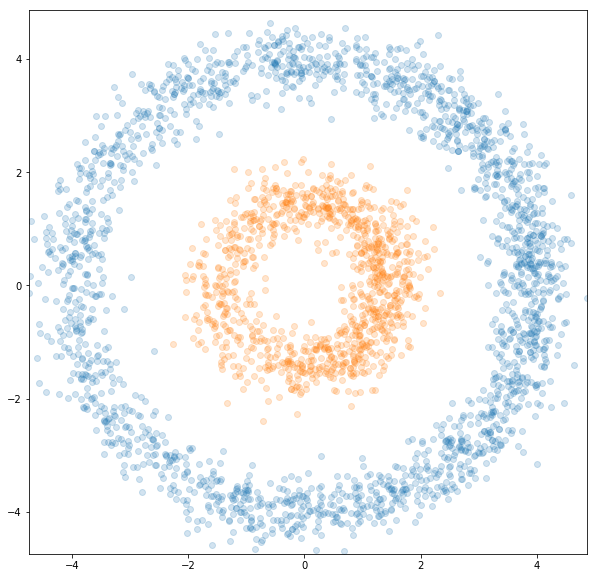

In [43]:
def transform(cluster):
    xs = cluster[:,0] * np.cos(cluster[:,1])
    ys = cluster[:,0] * np.sin(cluster[:,1])
    return np.concatenate([np.expand_dims(xs, -1), np.expand_dims(ys, -1)], axis=1)


class RingsDataSet(DataSet):

    cluster_1 = transform(np.random.multivariate_normal(
        mean=np.array([4.0, 0.0]),
        cov=np.array([[0.1, 0.0],
                      [0.0, 4.0]]),
        size=2000))

    cluster_2 = transform(np.random.multivariate_normal(
        mean=np.array([1.5, 0.0]),
        cov=np.array([[0.1, 0.0],
                      [0.0, 4.0]]),
        size=1000))

    @property
    def clusters(self):
        return [self.cluster_1, self.cluster_2]


display(RingsDataSet().clusters)

<br>

# Clusterization using K-means
---

K-means works by repeating 2 phases:

* Assign each point to its closest centroid (E step)
* Recompute each centroid as the mean of the points assigned to it (M step)

These 2 phases are a specific instance of the **EM** (Expectation Maximization) algorithm, that is garantied to converge, although not necessarily to a global maximum. K-means also requires the number of clusters K to be given as input.

<br>

### Simple data sets

K-means is very good at handling data-sets that are well enough separated, and for which the shape of the clusters is a kind of gaussian that is not to stretched. This means that K-means is extremly **sensitive to re-scaling** of the inputs.

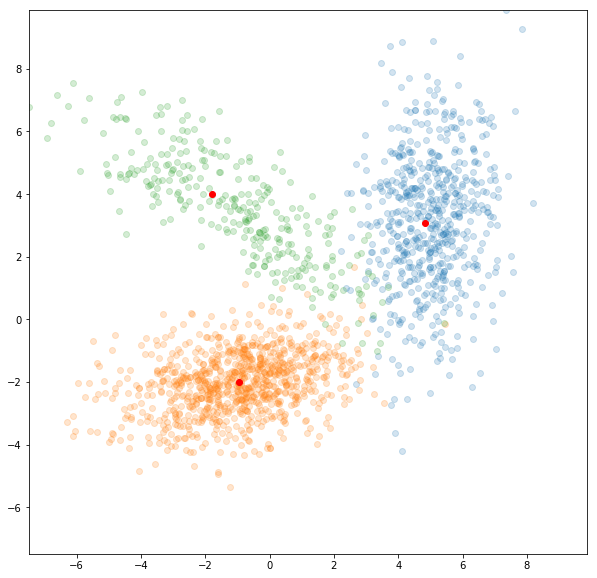

In [37]:
data_set = SimpleDataSet()

k_means = KMeans(n_clusters=3)
k_means.fit(data_st.all_points)

display(data_set.clusters, k_means.cluster_centers_)

<br>

### Quantization (example of images)

Clusterize the colors in channels (R,G,B,A) and compress the image by having a set of centroids, and just an array of integer index that references these centroids. We show what we get with this algorithm.

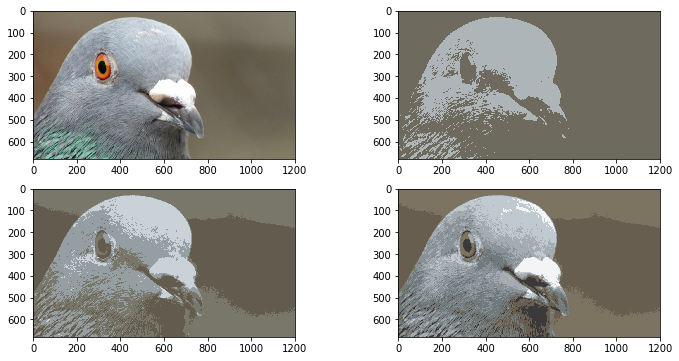

In [83]:
from PIL import Image

im = Image.open("dataset/pigeon.png")
pic = np.array(im.getdata())


def compress(im, n_clusters):
    k_means = KMeans(n_clusters=n_clusters)
    k_means.fit(pic)
    pred = k_means.predict(pic)
    centroids = k_means.cluster_centers_
    decompressed = centroids[pred]
    decompressed = decompressed.reshape(im.size[1], im.size[0], -1)
    return Image.fromarray(np.uint8(decompressed))


_, ax = plt.subplots(figsize=(12,6), ncols=2, nrows=2)
ax[0,0].imshow(im)
ax[0,1].imshow(compress(im,2))
ax[1,0].imshow(compress(im,4))
ax[1,1].imshow(compress(im,8))
plt.show()

<br>

### Pathological cases: thin clusters

A simple rescaling of the inputs can mess up with K-means, or instead be necessary to make it work. Below we show the example of two clusters that are thin and close to each other. Because of the euclidean distance criterion to group points, K-means will fail to find good centroids.

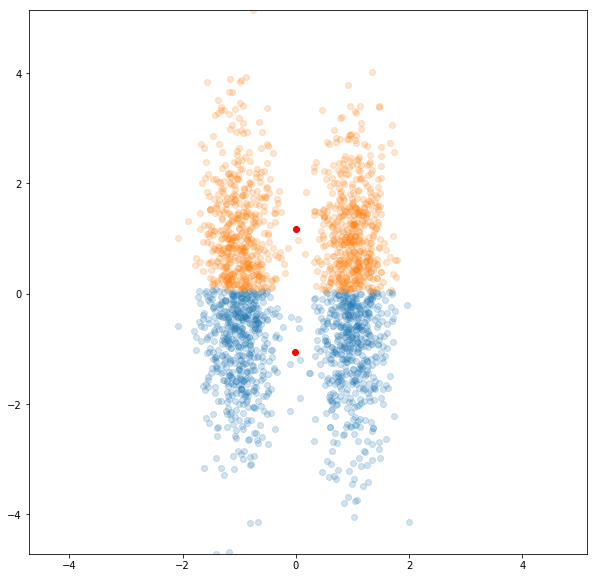

In [48]:
data_set = ThinClusters()
all_points = data_set.all_points

k_means = KMeans(n_clusters=2)
k_means.fit(all_points)

centroids = k_means.cluster_centers_
predictions = k_means.predict(all_points)
pred_1 = all_points[predictions == 0]
pred_2 = all_points[predictions == 1]

display([pred_1, pred_2], centroids)

<br>

### Non-gaussian shaped clusters

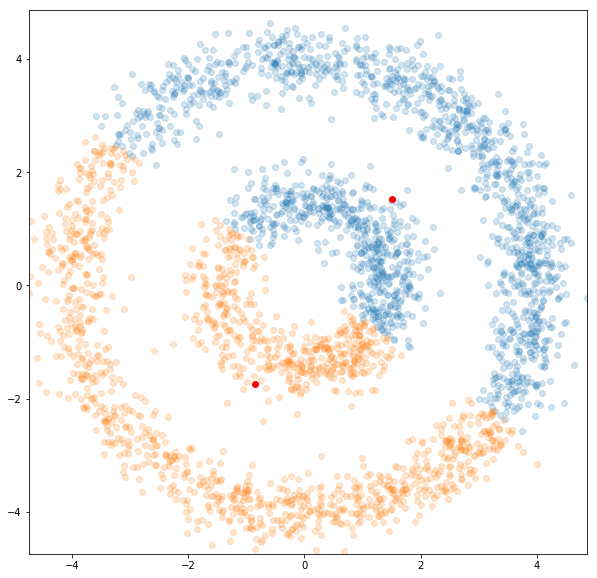

In [49]:
data_set = RingsDataSet()
all_points = data_set.all_points

k_means = KMeans(n_clusters=2)
k_means.fit(all_points)

centroids = k_means.cluster_centers_
predictions = k_means.predict(all_points)
pred_1 = all_points[predictions == 0]
pred_2 = all_points[predictions == 1]

display([pred_1, pred_2], centroids)

<br>

# Soft K-means & Gaussian Mixture Density Estimation
---

## Solving thin clusters

Soft K-means
* Each point has a "degree of belonging" to the cluster
* Each cluster has its own variance (or standard deviation)
* Each axis of each cluster has its own variance (allows stretched clusters)
* Each cluster has an "importance" based on the number of points it contains

Each of these factors are learned.
This is in fact a maximum likelihood based algorithm.

In [ ]:
# TODO

<br>

# Other useful clustering techniques
----

* Even if the cluster is generated using a gaussian law, it might be so in a different space
* In the projected space, we might have spirals, like shown below

<br>

## Kernel K-means

Kernel K-means: use a kernel function to compute the distances in a different space

In [20]:
# TODO

<br>

## Agglomerative Clustering

Recursively merges the pair of clusters that minimally increases a given linkage distance. Several mode exist (some to minimize the distance of individual links 'single', some to minimize the variance of a cluster 'ward').

It works in the this case, but because of the correct selection of 'linkage'.

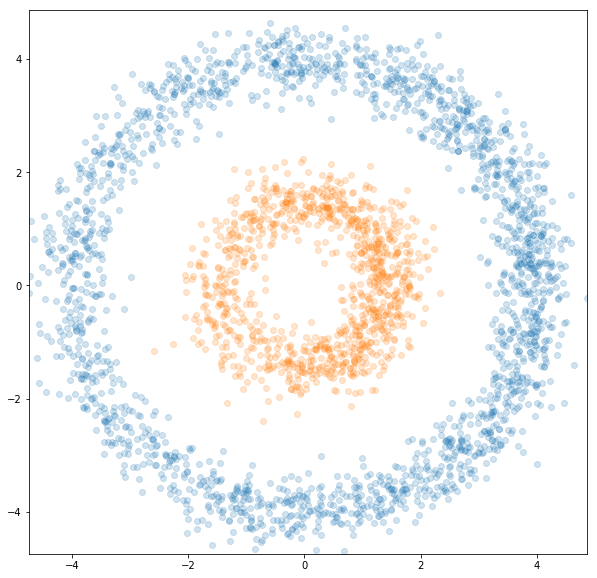

In [51]:
data_set = RingsDataSet()
all_points = data_set.all_points

aglo = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='single')
predictions = aglo.fit_predict(all_points)
pred_1 = all_points[predictions == 0]
pred_2 = all_points[predictions == 1]

display([pred_1, pred_2])

<br>

## Spectral clustering

https://en.wikipedia.org/wiki/Spectral_clustering

Spectral clustering: the general approach is to use a standard clustering method (ex: k-means) on relevant eigenvectors of a Laplacian matrix of A, a symmetric matrix representing the similiarities between the points.

The similarities are computed based on RBF such as $e^{-\gamma(x - y)^2}$ (if $\gamma = \frac{1}{\sigma^2}$, we have a gaussian)

If affinity is the adjacency matrix of a graph, this method can be used to find normalized graph cuts.

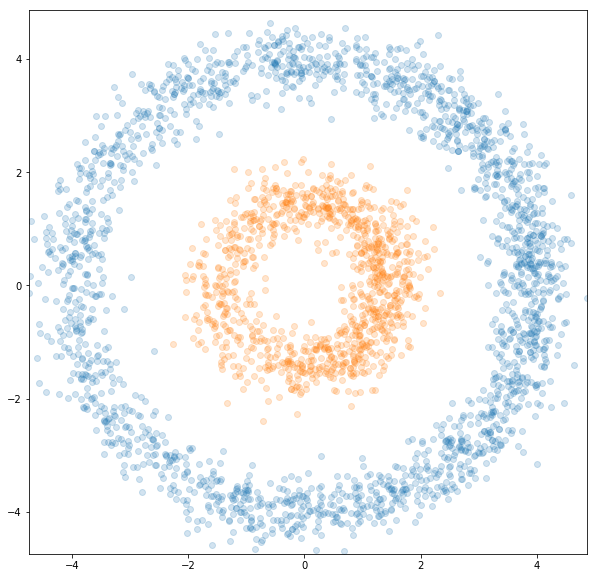

In [52]:
data_set = RingsDataSet()
all_points = data_set.all_points

s_cluster = SpectralClustering(n_clusters=2, affinity='rbf', assign_labels='kmeans')
predictions = s_cluster.fit_predict(all_points)
pred_1 = all_points[predictions == 0]
pred_2 = all_points[predictions == 1]

display([pred_1, pred_2])

It works pretty great on thin clusters as well

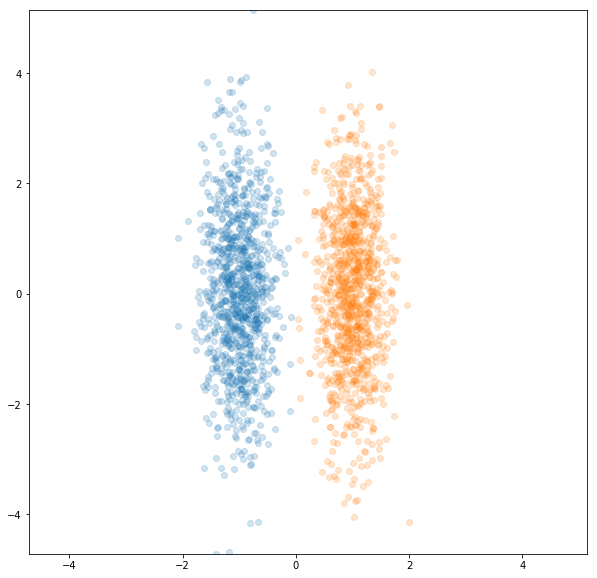

In [53]:
data_set = ThinClusters()
all_points = data_set.all_points

s_cluster = SpectralClustering(n_clusters=2, affinity='rbf', assign_labels='kmeans')
predictions = s_cluster.fit_predict(all_points)
pred_1 = all_points[predictions == 0]
pred_2 = all_points[predictions == 1]

display([pred_1, pred_2])